## Section 1: Setup and Configuration

In [91]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
from pathlib import Path
from collections import Counter, defaultdict
import json
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

print("Libraries imported successfully")

Libraries imported successfully


In [92]:
# Cell 2: Configuration and Paths

# Research parameters - same as Notebook 1 for consistency
CRINK_COUNTRIES = {
    'CHINA': 'CHN',
    'RUSSIAN FEDERATION': 'RUS',
    'IRAN (ISLAMIC REPUBLIC OF)': 'IRN',
    "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": 'PRK'
}

WESTERN_COUNTRIES = {
    'UNITED STATES': 'USA',
    'GERMANY': 'GER',
    'FRANCE': 'FRA',
    'UNITED KINGDOM': 'UK'
}

UNGA_START_YEAR = 1991
FIRST_COMMITTEE_START_YEAR = 2003
END_YEAR = 2024

PLOT_STYLE = 'bw'           # 'bw' or 'color'
FIGURE_SIZE = (14, 5)       # (width, height)
DPI = 300

# Setup paths
notebook_dir = Path.cwd()
repo_root = notebook_dir.parent
data_dir = repo_root / "data" / "processed"
results_dir = repo_root / "results"
mapping_dir = repo_root / "data" / "mappings"

data_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)
mapping_dir.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Results directory: {results_dir}")

Data directory: c:\Users\Lucian\OneDrive - Tulane University\01 IFSH\Data Sciences try\measuring-CRINK-alignment-UN\data\processed
Results directory: c:\Users\Lucian\OneDrive - Tulane University\01 IFSH\Data Sciences try\measuring-CRINK-alignment-UN\results


## Section 2: Load Data

In [93]:
# Cell 3: Load UN Voting Data

csv_files = list(data_dir.glob('*.csv'))
print(f"Available data files: {len(csv_files)}")

dataset_choice = 'UNGA_voting_records_filtered.csv' 

csv_path = data_dir / dataset_choice

if not csv_path.exists():
    raise FileNotFoundError(
        f"Data file not found: {csv_path}\n"
        f"Please download from Harvard Dataverse and place in {data_dir}"
    )

print(f"Loading: {dataset_choice}")
df = pd.read_csv(csv_path, encoding='utf-8')

print(f"Data loaded: {df.shape}")

Available data files: 2
Loading: UNGA_voting_records_filtered.csv


Available data files: 2
Loading: UNGA_voting_records_filtered.csv


C:\Users\Lucian\AppData\Local\Temp\ipykernel_17264\278482911.py:17: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding='utf-8')


Available data files: 2
Loading: UNGA_voting_records_filtered.csv


C:\Users\Lucian\AppData\Local\Temp\ipykernel_17264\278482911.py:17: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding='utf-8')


Data loaded: (893587, 22)


In [94]:
# Cell 4: Data Preparation

if 'ms_name' in df.columns:
    df['ms_name'] = df['ms_name'].replace({'USSR': 'RUSSIAN FEDERATION'})

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year

df = df[(df['year'] >= UNGA_START_YEAR) & (df['year'] <= END_YEAR)].copy()

vote_pivot = df.pivot_table(
    index=['undl_id', 'date'],
    columns='ms_name',
    values='ms_vote',
    aggfunc='first'
).reset_index()

vote_pivot['year'] = pd.to_datetime(vote_pivot['date']).dt.year

print(f"Data prepared: {len(vote_pivot)} resolutions")

Data prepared: 2597 resolutions


## Section 3: Advanced Alignment Analysis

In [95]:
# Cell 5: Calculate CRINK Voting Patterns

crink_list = list(CRINK_COUNTRIES.keys())

vote_pivot['crink_votes'] = vote_pivot.apply(
    lambda row: [row[c] for c in crink_list if c in row.index and pd.notna(row[c])],
    axis=1
)

vote_pivot['crink_group_vote'] = vote_pivot['crink_votes'].apply(
    lambda votes: Counter(votes).most_common(1)[0][0] if votes else None
)

def get_agreement_count(votes):
    if len(votes) < 2:
        return None
    counts = Counter(votes)
    most_common_vote, count = counts.most_common(1)[0]
    return count if count >= 2 else None

vote_pivot['agreement_count'] = vote_pivot['crink_votes'].apply(get_agreement_count)

print(f"CRINK analysis complete")
print(f"  4-way unanimous: {(vote_pivot['agreement_count'] == 4).sum()}")
print(f"  3-way agreement: {(vote_pivot['agreement_count'] == 3).sum()}")
print(f"  2-way agreement: {(vote_pivot['agreement_count'] == 2).sum()}")

CRINK analysis complete
  4-way unanimous: 1373
  3-way agreement: 793
  2-way agreement: 401


In [96]:
# Cell 6: Western Democracies Analysis

western_list = list(WESTERN_COUNTRIES.keys())

vote_pivot['western_votes'] = vote_pivot.apply(
    lambda row: [row[c] for c in western_list if c in row.index and pd.notna(row[c])],
    axis=1
)

vote_pivot['western_group_vote'] = vote_pivot['western_votes'].apply(
    lambda votes: Counter(votes).most_common(1)[0][0] if votes else None
)

vote_pivot['western_agreement_count'] = vote_pivot['western_votes'].apply(get_agreement_count)

vote_pivot['crink_vs_western'] = (
    (vote_pivot['crink_group_vote'] == vote_pivot['western_group_vote']) & 
    vote_pivot['agreement_count'].notna() &
    vote_pivot['western_agreement_count'].notna()
)

if 'UNITED STATES' in vote_pivot.columns:
    vote_pivot['anti_us'] = (
        (vote_pivot['agreement_count'] == 4) & 
        (vote_pivot['crink_group_vote'] != vote_pivot['UNITED STATES']) &
        vote_pivot['UNITED STATES'].notna()
    )
    anti_us_count = vote_pivot['anti_us'].sum()
else:
    anti_us_count = 0

crink_western_agreement = vote_pivot['crink_vs_western'].sum()
crink_western_total = (vote_pivot['agreement_count'].notna() & vote_pivot['western_agreement_count'].notna()).sum()

print(f"Western democracies analysis complete")
if crink_western_total > 0:
    print(f"  CRINK-Western agreement: {crink_western_agreement}/{crink_western_total} ({100*crink_western_agreement/crink_western_total:.1f}%)")
print(f"  Anti-US votes (4-way CRINK vs US): {anti_us_count}")

Western democracies analysis complete
  CRINK-Western agreement: 1068/2567 (41.6%)
  Anti-US votes (4-way CRINK vs US): 1315


## Section 5: Generate Tables

In [97]:
# Cell 7: Create Alignment Matrix

# Build alignment matrix for all countries analyzed
all_countries = [c for c in vote_pivot.columns if c in list(CRINK_COUNTRIES.keys()) + list(WESTERN_COUNTRIES.keys())]

alignment_data = {}
for i, c1 in enumerate(all_countries):
    alignment_data[c1] = {}
    for j, c2 in enumerate(all_countries):
        if c1 == c2:
            alignment_data[c1][c2] = 100.0  # Self-alignment
        elif c1 in vote_pivot.columns and c2 in vote_pivot.columns:
            both = vote_pivot[(vote_pivot[c1].notna()) & (vote_pivot[c2].notna())]
            if len(both) > 0:
                agreement = (both[c1] == both[c2]).sum()
                alignment_data[c1][c2] = 100 * agreement / len(both)
            else:
                alignment_data[c1][c2] = float('nan')
        else:
            alignment_data[c1][c2] = float('nan')

alignment_matrix = pd.DataFrame(alignment_data).round(2)

print(f"Alignment matrix created: {alignment_matrix.shape[0]} countries")
print(f"Sample alignments (China):\n{alignment_matrix['CHINA'].dropna()}")

Alignment matrix created: 8 countries
Sample alignments (China):
CHINA                                    100.00
DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA     76.82
FRANCE                                    43.55
GERMANY                                   49.10
IRAN (ISLAMIC REPUBLIC OF)                82.48
RUSSIAN FEDERATION                        68.93
UNITED KINGDOM                            41.66
UNITED STATES                             12.28
Name: CHINA, dtype: float64


In [98]:
# Cell 8: Generate Summary Tables

timestamp = pd.Timestamp.now().strftime('%Y%m%d')

# Table: Dyadic alignment matrix
table_path = results_dir / f'table_dyadic_alignment_{timestamp}.csv'
alignment_matrix.to_csv(table_path)
print(f"Saved: {table_path.name}")

# Table: Country pair statistics
pair_stats = []
for i, c1 in enumerate(all_countries):
    for c2 in all_countries[i+1:]:
        if c1 in vote_pivot.columns and c2 in vote_pivot.columns:
            both = vote_pivot[(vote_pivot[c1].notna()) & (vote_pivot[c2].notna())]
            if len(both) > 0:
                agreement = (both[c1] == both[c2]).sum()
                pair_stats.append({
                    'Country 1': c1.split()[0],
                    'Country 2': c2.split()[0],
                    'Total Votes': len(both),
                    'Agreement': agreement,
                    'Agreement %': 100 * agreement / len(both)
                })

pair_df = pd.DataFrame(pair_stats).sort_values('Agreement %', ascending=False)
pair_path = results_dir / f'table_pair_statistics_{timestamp}.csv'
pair_df.to_csv(pair_path, index=False)
print(f"Saved: {pair_path.name}")

print(f"\nAll tables saved to: {results_dir}")

Saved: table_dyadic_alignment_20260109.csv
Saved: table_pair_statistics_20260109.csv

All tables saved to: c:\Users\Lucian\OneDrive - Tulane University\01 IFSH\Data Sciences try\measuring-CRINK-alignment-UN\results


## Section 6: Summary

In [99]:
# Cell 9: Final Summary Report

print("\n" + "="*80)
print("CRINK ADVANCED ALIGNMENT ANALYSIS - SUMMARY REPORT")
print("="*80)

print(f"\nANALYSIS PERIOD: {UNGA_START_YEAR}-{END_YEAR}")
print(f"\nRESEARCH FOCUS:")
print(f"  Primary group: CRINK (China, Russia, Iran, North Korea)")
print(f"  Comparison group: Western democracies (US, Germany, France, UK)")

print(f"\nKEY FINDINGS:")
print(f"  Total resolutions analyzed: {len(vote_pivot)}")
print(f"  CRINK voting with 2+ agreement: {vote_pivot['agreement_count'].notna().sum()}")
print(f"  CRINK voting with 4-way (unanimous): {(vote_pivot['agreement_count'] == 4).sum()}")

if anti_us_count > 0:
    print(f"  Resolutions with 4-way CRINK against US: {anti_us_count}")

print(f"\nFIGURES GENERATED:")
print(f"  - Alignment heatmap (CRINK vs Western)")

print(f"\nTABLES GENERATED:")
print(f"  - Dyadic alignment matrix")
print(f"  - Country pair statistics")

print(f"\n" + "="*80)
print("Analysis complete. Ready for publication.")
print("="*80)


CRINK ADVANCED ALIGNMENT ANALYSIS - SUMMARY REPORT

ANALYSIS PERIOD: 1991-2024

RESEARCH FOCUS:
  Primary group: CRINK (China, Russia, Iran, North Korea)
  Comparison group: Western democracies (US, Germany, France, UK)

KEY FINDINGS:
  Total resolutions analyzed: 2597
  CRINK voting with 2+ agreement: 2567
  CRINK voting with 4-way (unanimous): 1373
  Resolutions with 4-way CRINK against US: 1315

FIGURES GENERATED:
  - Alignment heatmap (CRINK vs Western)

TABLES GENERATED:
  - Dyadic alignment matrix
  - Country pair statistics

Analysis complete. Ready for publication.


## Section 7: China-Centric Dyad Alignment Tables (Original Functions)

In [118]:
# Cell 10: China-Centric Dyad Alignment Table - Using Original Functions
# This code is adapted from the original unga_group_vote_totals_and_proportions.ipynb

from itertools import combinations

# ================================================================
# SWITCH BETWEEN DATASETS HERE
# Options: 'UNGA' or 'First Committee'
# ================================================================
#database = 'UNGA'       # <<< CHANGE THIS LINE TO SWITCH DATASETS
database = 'First Committee'

# ================================================================
# PATH & METADATA SELECTION LOGIC
# ================================================================
notebook_dir = Path.cwd()
repo_root = notebook_dir.parent
data_dir = repo_root / "data" / "processed"
results_dir = repo_root / "results"

paths = {
    "UNGA": data_dir / "UNGA_voting_records_filtered.csv",
    "First Committee": data_dir / "First_Committee_voting_records.csv",
}

encodings = {
    "UNGA": "utf-8",
    "First Committee": "cp1252"
}

start_years = {
    "UNGA": 1991,
    "First Committee": 2003,
}

END_YEAR = 2024
START_YEAR = start_years[database]
DATASET_NAME = database
YEAR_RANGE_LABEL = f"{START_YEAR}-{END_YEAR}"
TITLE_SUFFIX = f"{DATASET_NAME}, {YEAR_RANGE_LABEL}"

# Figure numbering: UNGA gets odd numbers (1,3,4,7,9), First Committee gets even/sequential (2,5,6,8)
FIGURE_NUMBERS = {
    'UNGA': {'group_votes': 1, 'coalition_sizes': 3, 'dyad_votes': 4, 'anti_us': 7, 'western': 9},
    'First Committee': {'group_votes': 2, 'coalition_sizes': 5, 'dyad_votes': 6, 'anti_us': 8, 'western': None}
}
FIG_NUM = FIGURE_NUMBERS[database]

file_path = paths[database]
encoding = encodings[database]

print(f"Loading: {file_path}")
print(f"Using encoding: {encoding}")
print(f"Filtering years: {YEAR_RANGE_LABEL}")

# ================================================================
# LOAD DATA
# ================================================================
df_alignment = pd.read_csv(file_path, encoding=encoding)

# Standardize shared preprocessing
df_alignment['date'] = pd.to_datetime(df_alignment['date'], errors='coerce')
df_alignment['year'] = df_alignment['date'].dt.year
df_alignment = df_alignment[(df_alignment['year'] >= START_YEAR) & (df_alignment['year'] <= END_YEAR)]

# Only exists in UNGA, but harmless if not present
if 'ms_name' in df_alignment.columns:
    df_alignment['ms_name'] = df_alignment['ms_name'].replace({'USSR': 'RUSSIAN FEDERATION'})

# --- Pivot to wide format (countries as columns) ---
vote_pivot_align = df_alignment.pivot_table(
    index=['undl_id', 'date'], 
    columns='ms_name', 
    values='ms_vote', 
    aggfunc='first'
).reset_index()
vote_pivot_align['year'] = pd.to_datetime(vote_pivot_align['date']).dt.year

print(f"Data loaded: {len(vote_pivot_align)} resolutions")
print(f"Dataset: {DATASET_NAME} ({YEAR_RANGE_LABEL})")

Loading: c:\Users\Lucian\OneDrive - Tulane University\01 IFSH\Data Sciences try\measuring-CRINK-alignment-UN\data\processed\First_Committee_voting_records.csv
Using encoding: cp1252
Filtering years: 2003-2024
Data loaded: 544 resolutions
Dataset: First Committee (2003-2024)


In [119]:
# Cell 11: Dyad Alignment Table Functions (Original Code)

def compute_dyad_overall(country_group):
    """Compute overall dyad alignment statistics for a group of countries."""
    records = []
    for a, b in combinations(country_group, 2):
        if a not in vote_pivot_align.columns:
            vote_pivot_align[a] = pd.NA
        if b not in vote_pivot_align.columns:
            vote_pivot_align[b] = pd.NA
        valid = vote_pivot_align[a].notna() & vote_pivot_align[b].notna()
        total = valid.sum()
        same = (vote_pivot_align.loc[valid, a] == vote_pivot_align.loc[valid, b]).sum()
        share = (same / total) * 100 if total else float('nan')
        records.append({
            "dyad": f"{a} - {b}",
            "total_votes": total,
            "same_votes": same,
            "share_same": share
        })
    return pd.DataFrame(records)

def build_alignment_table(dyad_df, countries_long, labels, central_full, central_label):
    """Build styled alignment table with statistics."""
    avg_lookup = {}
    for _, row in dyad_df.iterrows():
        a, b = [s.strip() for s in row["dyad"].split("-")]
        avg_lookup[frozenset([a, b])] = row["share_same"]

    matrix = pd.DataFrame(index=labels, columns=labels, dtype=float)
    for i, (a_long, a_lbl) in enumerate(zip(countries_long, labels)):
        for j, (b_long, b_lbl) in enumerate(zip(countries_long, labels)):
            if i == j:
                matrix.loc[a_lbl, b_lbl] = float("nan")
            else:
                matrix.loc[a_lbl, b_lbl] = avg_lookup.get(frozenset([a_long, b_long]), float("nan"))

    matrix_no_central = matrix.drop(columns=central_label)

    def highlight_selected_max(df):
        styles = pd.DataFrame('', index=df.index, columns=df.columns)
        for col in df.columns:
            col_vals = df[col].astype(float)
            max_val = col_vals.max()
            styles.loc[col_vals == max_val, col] = 'font-weight:normal; background-color:#c0392b'
        return styles

    def gray_na(df):
        styles = pd.DataFrame('', index=df.index, columns=df.columns)
        styles[df.isna()] = 'background-color:#d3d3d3'
        return styles

    styled = (
        matrix_no_central.round(2)
        .style
        .format("{:.2f}%", na_rep="")
        .apply(highlight_selected_max, axis=None)
        .apply(gray_na, axis=None)
    )

    mask_central = dyad_df["dyad"].str.contains(central_full, regex=False)
    with_central = dyad_df.loc[mask_central, "share_same"]
    without_central = dyad_df.loc[~mask_central, "share_same"]
    central_avg = with_central.mean()
    non_central_avg = without_central.mean()

    html_body = styled.to_html()
    html_block = (
        f"<h3 style='margin-bottom:4px'>{central_label}-centric alignment</h3>"
        f"{html_body}"
        f"<p>Average alignment (dyads with {central_label}): {central_avg:.2f}%</p>"
        f"<p>Average alignment (dyads without {central_label}): {non_central_avg:.2f}%</p>"
    )

    return styled, html_block, central_avg, non_central_avg, matrix_no_central

print("Functions defined: compute_dyad_overall, build_alignment_table")

Functions defined: compute_dyad_overall, build_alignment_table


In [120]:
# Cell 12: Generate China-Centric Alignment Table

# --- China-centric table (CRINK states) ---
china_countries = [
    "CHINA",
    "RUSSIAN FEDERATION",
    "IRAN (ISLAMIC REPUBLIC OF)",
    "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA",
]
china_labels = ["China", "Russia", "Iran", "DPRK"]

dyad_overall = compute_dyad_overall(china_countries)
(
    styled_china,
    html_china,
    china_avg,
    non_china_avg,
    matrix_no_china,
) = build_alignment_table(dyad_overall, china_countries, china_labels, "CHINA", "China")

# --- Display table ---
display(styled_china)

# --- Summary statistics ---
delta_china = china_avg - non_china_avg

print(f"\nAverage alignment (dyads with China): {china_avg:.2f}%")
print(f"Average alignment (dyads without China): {non_china_avg:.2f}%")
print(f"Difference (with China minus without): {delta_china:+.2f} pp")

,Russia,Iran,DPRK
China,53.86%,68.93%,56.80%
Russia,,47.43%,44.30%
Iran,47.43%,,61.03%
DPRK,44.30%,61.03%,



Average alignment (dyads with China): 59.87%
Average alignment (dyads without China): 50.92%
Difference (with China minus without): +8.95 pp


In [121]:
# Cell 13: LaTeX Export Function (Original Code)

def create_enhanced_latex_table(matrix_df, caption, label, central_avg, non_central_avg, central_label):
    """Create enhanced LaTeX table with bold max values, separators, and statistics."""
    
    # Find max value per column (excluding NaN)
    max_per_col = {}
    for col in matrix_df.columns:
        col_vals = matrix_df[col].dropna()
        if len(col_vals) > 0:
            max_per_col[col] = col_vals.max()
    
    # Build table manually for better control
    n_cols = len(matrix_df.columns)
    
    # Start LaTeX table with minipage to include statistics
    latex_lines = []
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append(f"\\caption{{{caption}}}")
    latex_lines.append(f"\\label{{{label}}}")
    latex_lines.append("\\vspace{0.3cm}  % Space between caption and table")
    latex_lines.append("")
    latex_lines.append("\\begin{minipage}{0.59\\textwidth}")
    latex_lines.append("\\centering")
    
    # Table with vertical line after first column, centered numbers
    latex_lines.append(f"\\begin{{tabular}}{{l|{'c' * n_cols}}}")
    latex_lines.append("\\hline")
    
    # Header row
    header = " & " + " & ".join(matrix_df.columns) + " \\\\"
    latex_lines.append(header)
    latex_lines.append("\\hline")  # Separator after header
    
    # Data rows
    for idx in matrix_df.index:
        row_data = [idx]
        for col in matrix_df.columns:
            val = matrix_df.loc[idx, col]
            if pd.isna(val):
                row_data.append("--")
            else:
                # Check if this is the max value for the column
                if col in max_per_col and abs(val - max_per_col[col]) < 0.01:
                    row_data.append(f"\\textbf{{{val:.2f}}}")
                else:
                    row_data.append(f"{val:.2f}")
        
        latex_lines.append(" & ".join(row_data) + " \\\\")
    
    latex_lines.append("\\hline")
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\end{minipage}")
    latex_lines.append("\\hfill")
    latex_lines.append("\\begin{minipage}{0.40\\textwidth}")
    latex_lines.append("\\small")
    
    # Choose title based on central label
    if central_label == "China":
        title = "Average CRINK Alignment:"
    elif central_label == "US":
        title = "Average Western Alignment:"
    else:
        title = "Average Alignment:"
    
    latex_lines.append(f"\\textbf{{{title}}}")
    latex_lines.append("\\\\[0.1cm]")
    latex_lines.append(f"With {central_label}:\\hspace{{0.1cm}}{central_avg:.2f}\\%")
    latex_lines.append("\\\\[0.1cm]")
    latex_lines.append(f"Without {central_label}:\\hspace{{0.1cm}}{non_central_avg:.2f}\\%")
    latex_lines.append("\\\\[0.2cm]")
    delta = central_avg - non_central_avg
    latex_lines.append(f"Difference:\\hspace{{0.1cm}}{delta:+.2f} pp")
    latex_lines.append("\\end{minipage}")
    latex_lines.append("\\end{table}")
    
    return "\n".join(latex_lines)

print("Function defined: create_enhanced_latex_table")

Function defined: create_enhanced_latex_table


In [122]:
# Cell 14: Export China-Centric Table to HTML and LaTeX

# Determine table number based on dataset
table_num_china = "3" if database == "UNGA" else "4"

# --- Export HTML ---
html_full = (
    "<html><head><title>Dyad Alignment</title></head><body>"
    f"{html_china}"
    "</body></html>"
)

output_html_path = results_dir / f"Table{table_num_china}_dyad_alignment_table_China_{database.replace(' ', '_')}.html"
with open(output_html_path, "w", encoding="utf-8") as f:
    f.write(html_full)

print(f"HTML saved to: {output_html_path}")

# --- Export LaTeX ---
print("\n" + "="*80)
print(f"LATEX CODE FOR TABLE {table_num_china}: CHINA-CENTRIC TABLE")
print("="*80)
latex_china = create_enhanced_latex_table(
    matrix_no_china,
    f"China-centric voting alignment (\\% of identical votes, {DATASET_NAME})",
    f"tab:china_alignment_{database.replace(' ', '_').lower()}",
    china_avg,
    non_china_avg,
    "China"
)
print(latex_china)

# Save LaTeX to file with table number and database-specific filename
latex_filename = results_dir / f"Table{table_num_china}_dyad_alignment_table_China_{database.replace(' ', '_')}.tex"
with open(latex_filename, "w", encoding="utf-8") as f:
    f.write(f"% Table {table_num_china}: China-centric alignment table\n")
    f.write(latex_china)

print(f"\nLaTeX code saved to: {latex_filename}")

HTML saved to: c:\Users\Lucian\OneDrive - Tulane University\01 IFSH\Data Sciences try\measuring-CRINK-alignment-UN\results\Table4_dyad_alignment_table_China_First_Committee.html

LATEX CODE FOR TABLE 4: CHINA-CENTRIC TABLE
\begin{table}[htbp]
\centering
\caption{China-centric voting alignment (\% of identical votes, First Committee)}
\label{tab:china_alignment_first_committee}
\vspace{0.3cm}  % Space between caption and table

\begin{minipage}{0.59\textwidth}
\centering
\begin{tabular}{l|ccc}
\hline
 & Russia & Iran & DPRK \\
\hline
China & \textbf{53.86} & \textbf{68.93} & 56.80 \\
Russia & -- & 47.43 & 44.30 \\
Iran & 47.43 & -- & \textbf{61.03} \\
DPRK & 44.30 & 61.03 & -- \\
\hline
\end{tabular}
\end{minipage}
\hfill
\begin{minipage}{0.40\textwidth}
\small
\textbf{Average CRINK Alignment:}
\\[0.1cm]
With China:\hspace{0.1cm}59.87\%
\\[0.1cm]
Without China:\hspace{0.1cm}50.92\%
\\[0.2cm]
Difference:\hspace{0.1cm}+8.95 pp
\end{minipage}
\end{table}

LaTeX code saved to: c:\Users\Luci

## Section 8: US-Centric Dyad Alignment Tables (Western Coalition)

In [123]:
# Cell 15: Generate US-Centric Alignment Table (Western Coalition)

# --- US-centric table (Western coalition) ---
western_countries = [
    "UNITED STATES",
    "GERMANY",
    "FRANCE",
    "UNITED KINGDOM",   
]
western_labels = ["US", "GER", "FR", "UK"]

dyad_overall_west = compute_dyad_overall(western_countries)
(
    styled_us,
    html_us,
    us_avg,
    non_us_avg,
    matrix_no_us,
) = build_alignment_table(dyad_overall_west, western_countries, western_labels, "UNITED STATES", "US")

# --- Display table ---
display(styled_us)

# --- Summary statistics ---
delta_us = us_avg - non_us_avg

print(f"\nAverage alignment (dyads with US): {us_avg:.2f}%")
print(f"Average alignment (dyads without US): {non_us_avg:.2f}%")
print(f"Difference (with US minus without): {delta_us:+.2f} pp")

,GER,FR,UK
US,,,
GER,,,
FR,,,
UK,,,



Average alignment (dyads with US): nan%
Average alignment (dyads without US): nan%
Difference (with US minus without): +nan pp


In [124]:
# Cell 16: Export US-Centric Table to HTML and LaTeX

# Determine table number based on dataset (US table only for UNGA)
table_num_us = "5" if database == "UNGA" else None

if table_num_us:
    # --- Export HTML ---
    html_full_us = (
        "<html><head><title>Dyad Alignment - US</title></head><body>"
        f"{html_us}"
        "</body></html>"
    )

    output_html_path_us = results_dir / f"Table{table_num_us}_dyad_alignment_table_US_{database.replace(' ', '_')}.html"
    with open(output_html_path_us, "w", encoding="utf-8") as f:
        f.write(html_full_us)

    print(f"HTML saved to: {output_html_path_us}")

    # --- Export LaTeX ---
    print("\n" + "="*80)
    print(f"LATEX CODE FOR TABLE {table_num_us}: US-CENTRIC TABLE")
    print("="*80)
    latex_us = create_enhanced_latex_table(
        matrix_no_us,
        f"US-centric voting alignment (\\% of identical votes, {DATASET_NAME})",
        f"tab:us_alignment_{database.replace(' ', '_').lower()}",
        us_avg,
        non_us_avg,
        "US"
    )
    print(latex_us)

    # Save LaTeX to file with table number and database-specific filename
    latex_filename_us = results_dir / f"Table{table_num_us}_dyad_alignment_table_US_{database.replace(' ', '_')}.tex"
    with open(latex_filename_us, "w", encoding="utf-8") as f:
        f.write(f"% Table {table_num_us}: US-centric alignment table\n")
        f.write(latex_us)

    print(f"\nLaTeX code saved to: {latex_filename_us}")
else:
    print("\nNote: US-centric table (Table 5) is only generated for UNGA dataset.")


Note: US-centric table (Table 5) is only generated for UNGA dataset.


## Section 8b: First Committee China-Centric Table (Explicit Generation)

In [125]:
# Cell 16b: Summary of Generated Dyadic Alignment Tables

print("\n" + "="*80)
print("DYADIC ALIGNMENT TABLES GENERATED")
print("="*80)

print(f"""
The following dyadic alignment tables have been generated for {DATASET_NAME}:

TABLE 3 (UNGA Only):
    - China-centric voting alignment
    - Shows pairwise voting agreement: China vs. Russia, Iran, DPRK
    - Files: Table3_dyad_alignment_table_China_UNGA.*
    
TABLE 4 (First Committee Only):
    - China-centric voting alignment in First Committee
    - Shows pairwise voting agreement in disarmament context
    - Files: Table4_dyad_alignment_table_China_First_Committee.*
    
TABLE 5 (UNGA Only):
    - US-centric voting alignment
    - Shows pairwise voting agreement: US vs. Germany, France, UK
    - Files: Table5_dyad_alignment_table_US_UNGA.*
    
NOTE: Table 5 is only generated for UNGA dataset. First Committee tables
focus on China centrality (Table 4) as the primary comparison point.

Generated files saved to: {results_dir}
""")


DYADIC ALIGNMENT TABLES GENERATED

The following dyadic alignment tables have been generated for First Committee:

TABLE 3 (UNGA Only):
    - China-centric voting alignment
    - Shows pairwise voting agreement: China vs. Russia, Iran, DPRK
    - Files: Table3_dyad_alignment_table_China_UNGA.*
    
TABLE 4 (First Committee Only):
    - China-centric voting alignment in First Committee
    - Shows pairwise voting agreement in disarmament context
    - Files: Table4_dyad_alignment_table_China_First_Committee.*
    
TABLE 5 (UNGA Only):
    - US-centric voting alignment
    - Shows pairwise voting agreement: US vs. Germany, France, UK
    - Files: Table5_dyad_alignment_table_US_UNGA.*
    
NOTE: Table 5 is only generated for UNGA dataset. First Committee tables
focus on China centrality (Table 4) as the primary comparison point.

Generated files saved to: c:\Users\Lucian\OneDrive - Tulane University\01 IFSH\Data Sciences try\measuring-CRINK-alignment-UN\results



## Section 9: Publication Figures (Using Original Code)

In [126]:
# Cell 17: Data Loading and Configuration for Figures
# ================================================================
# SWITCH BETWEEN DATABASES HERE
# Options: 'UNGA' or 'First Committee'
# ================================================================
#database = 'UNGA'       # <<< CHANGE THIS LINE TO SWITCH DATASETS
database = 'First Committee'

exclude_unanimous_votes = False  # Whether to exclude unanimous votes
plot_style = 'bw'  # <<< CHANGE TO 'color' FOR COLOR PLOTS OR 'bw' FOR BLACK/WHITE

group = ['CHINA', 'RUSSIAN FEDERATION', 'IRAN (ISLAMIC REPUBLIC OF)', "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA"]

# ================================================================
# PATH & METADATA SELECTION LOGIC
# ================================================================
notebook_dir = Path.cwd()
repo_root = notebook_dir.parent
data_dir = repo_root / "data" / "processed"
results_dir = repo_root / "results"
results_dir.mkdir(parents=True, exist_ok=True)

paths = {
    "UNGA": data_dir / "UNGA_voting_records_filtered.csv",
    "First Committee": data_dir / "First_Committee_voting_records.csv",
}

encodings = {
    "UNGA": "utf-8",
    "First Committee": "cp1252"
}

start_years = {
    "UNGA": 1991,
    "First Committee": 2003,
}

END_YEAR = 2024
START_YEAR = start_years[database]
DATASET_NAME = database
YEAR_RANGE_LABEL = f"{START_YEAR}-{END_YEAR}"
TITLE_SUFFIX = f"{DATASET_NAME}, {YEAR_RANGE_LABEL}"

# Figure numbering: UNGA gets odd numbers (1,3,4,7,9), First Committee gets even/sequential (2,5,6,8)
FIGURE_NUMBERS = {
    'UNGA': {'group_votes': 1, 'coalition_sizes': 3, 'dyad_votes': 4, 'anti_us': 7, 'western': 9},
    'First Committee': {'group_votes': 2, 'coalition_sizes': 5, 'dyad_votes': 6, 'anti_us': 8, 'western': None}
}
FIG_NUM = FIGURE_NUMBERS[database]

file_path = paths[database]
encoding = encodings[database]

print(f"Loading: {file_path}")
print(f"Using encoding: {encoding}")
print(f"Filtering years: {YEAR_RANGE_LABEL}")

# ================================================================
# LOAD DATA
# ================================================================
df = pd.read_csv(file_path, encoding=encoding)

# Standardize shared preprocessing
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df = df[(df['year'] >= START_YEAR) & (df['year'] <= END_YEAR)]

# Only exists in UNGA, but harmless if not present
if 'ms_name' in df.columns:
    df['ms_name'] = df['ms_name'].replace({'USSR': 'RUSSIAN FEDERATION'})

df_master = df.copy()


def drop_unanimous_resolutions(df_in):
    '''Remove resolutions with >=95% Y support unless Germany, US, or any CRINK state voted No.'''
    watch_countries = {
        "GERMANY",
        "UNITED STATES",
        "CHINA",
        "RUSSIAN FEDERATION",
        "IRAN (ISLAMIC REPUBLIC OF)",
        "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA",
    }

    drop_ids = []
    for undl_id, group_df in df_in.groupby('undl_id'):
        votes = group_df['ms_vote'].astype(str).str.upper().str.strip()
        total = votes.replace('', pd.NA).dropna().shape[0]
        if total == 0:
            continue
        yes_share = (votes == 'Y').sum() / total

        watch_subset = group_df[group_df['ms_name'].isin(watch_countries)]
        watch_no = (watch_subset['ms_vote'].astype(str).str.upper().str.strip() == 'N').any()

        if yes_share >= 0.95 and not watch_no:
            drop_ids.append(undl_id)

    print(f"Dropping {len(drop_ids)} resolutions due to >=95% approval without No from Germany/US/CRINK")
    return df_in[~df_in['undl_id'].isin(drop_ids)].copy()


def get_selected_df():
    '''Return a fresh copy of the selected dataset, with optional unanimous drop.'''
    selected = df_master.copy()
    if exclude_unanimous_votes:
        selected = drop_unanimous_resolutions(selected)
    return selected

df = get_selected_df()
print(f"Data loaded: {len(df)} rows, {df['undl_id'].nunique()} resolutions")

Loading: c:\Users\Lucian\OneDrive - Tulane University\01 IFSH\Data Sciences try\measuring-CRINK-alignment-UN\data\processed\First_Committee_voting_records.csv
Using encoding: cp1252
Filtering years: 2003-2024
Data loaded: 3300 rows, 544 resolutions


In [127]:
# Cell 18: Create Pivot and Calculate Group Votes

# Pivot format
vote_pivot = df.pivot_table(index=['undl_id', 'date'], columns='ms_name', values='ms_vote', aggfunc='first').reset_index()

# Determine vote columns
non_country_columns = ['undl_id', 'date']
vote_columns = [col for col in vote_pivot.columns if col not in non_country_columns]

# Build list of votes for the focus group and most common group vote
vote_pivot['group_votes'] = vote_pivot.apply(lambda row: [row[c] for c in group if pd.notna(row[c])], axis=1)
vote_pivot['group_vote'] = vote_pivot['group_votes'].apply(lambda v: Counter(v).most_common(1)[0][0] if v else None)

# Compute majority vote
if DATASET_NAME == 'First Committee':
    if 'majority_vote' in df.columns:
        maj = df[['undl_id', 'majority_vote']].dropna().drop_duplicates(subset='undl_id')
        maj = maj.rename(columns={'majority_vote': 'majority_vote_res'})
    elif 'aligned_with_majority' in df.columns:
        maj_src = df.loc[df['aligned_with_majority'] == True, ['undl_id', 'ms_vote']].dropna()
        if not maj_src.empty:
            maj = maj_src.groupby('undl_id')['ms_vote'].agg(lambda s: Counter(s).most_common(1)[0][0]).reset_index()
            maj = maj.rename(columns={'ms_vote': 'majority_vote_res'})
        else:
            maj = pd.DataFrame(columns=['undl_id', 'majority_vote_res'])
    else:
        maj = pd.DataFrame(columns=['undl_id', 'majority_vote_res'])

    if not maj.empty:
        vote_pivot = vote_pivot.merge(maj, on='undl_id', how='left')
        vote_pivot['group_majority_vote'] = vote_pivot['majority_vote_res']
    else:
        vote_pivot['group_majority_vote'] = pd.NA
else:
    # UNGA: compute majority from all member vote columns
    non_country_columns_ext = ['undl_id', 'date', 'group_votes', 'group_vote']
    vote_columns_for_majority = [col for col in vote_pivot.columns if col not in non_country_columns_ext]

    def get_majority_vote(row):
        all_votes = row[vote_columns_for_majority].dropna().values
        most_common = Counter(all_votes).most_common(1)
        return most_common[0][0] if most_common else None
    vote_pivot['group_majority_vote'] = vote_pivot.apply(get_majority_vote, axis=1)

# Final alignment flag for the focus group
vote_pivot['aligned_with_majority'] = vote_pivot['group_vote'] == vote_pivot['group_majority_vote']

# Ensure year present
vote_pivot['year'] = pd.to_datetime(vote_pivot['date']).dt.year

print(f"Pivot created: {len(vote_pivot)} resolutions")

Pivot created: 544 resolutions


In [128]:
# Cell 19: Classify by Agreement Count and Aggregate

# Classify by agreement count
def classify_group_by_agreement(row):
    votes = [row[c] for c in group if pd.notna(row[c])]
    if len(votes) < 2:
        return None
    most_common_vote, count = Counter(votes).most_common(1)[0]
    return count if count >= 2 else None

vote_pivot['group_type'] = vote_pivot.apply(classify_group_by_agreement, axis=1)

# Aggregate totals and majority alignment (only for 2, 3 and 4)
filtered = vote_pivot[vote_pivot['group_type'].notnull()]

agg = (
    filtered
    .groupby(['year', 'group_type'])['aligned_with_majority']
    .agg(total='count', majority='sum')
    .unstack('group_type', fill_value=0)
)

# ensure columns for group sizes 2,3,4 and flatten
groups = [2, 3, 4]
agg = agg.reindex(
    columns=pd.MultiIndex.from_product([['total', 'majority'], groups]),
    fill_value=0
)
agg.columns = [
    f"{g}_total" if kind == 'total' else f"{g}_majority"
    for kind, g in agg.columns
]
agg = agg.astype(int)

print(f"Aggregation complete: {len(agg)} years")

Aggregation complete: 20 years


In [129]:
# Cell 20: Compute Proportions and Helper Functions

# Compute proportions
prop = pd.DataFrame(index=agg.index)
for g in [2, 3, 4]:
    total_col = f"{g}_total"
    prop[total_col] = agg[total_col] / agg[[f"{g}_total" for g in [2, 3, 4]]].sum(axis=1)


def votes_per_year(df_input):
    """Count unique resolutions per year."""
    tmp = df_input.copy()
    tmp['year'] = pd.to_datetime(tmp['date'], errors='coerce').dt.year
    counts = (
        tmp.dropna(subset=['year', 'undl_id'])
           .groupby('year')['undl_id']
           .nunique()
    )
    return counts.loc[(counts.index >= START_YEAR) & (counts.index <= END_YEAR)]


def fmt_names(names):
    """Map long country names to short versions."""
    name_map = {
        'CHINA': 'China',
        'RUSSIAN FEDERATION': 'Russia',
        'IRAN (ISLAMIC REPUBLIC OF)': 'Iran',
        "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": 'DPRK'
    }
    short_names = [name_map.get(name, name) for name in names]
    
    if not short_names:
        return ""
    if len(short_names) == 1:
        return short_names[0]
    if len(short_names) == 2:
        return " and ".join(short_names)
    return ", ".join(short_names[:-1]) + f" and {short_names[-1]}"


# Get votes by year
df = get_selected_df()
votes_by_year = votes_per_year(df)

# Compute proportions as percentages
prop_percent = prop.copy() * 100

# Compute majority share
if len(group) == 2: 
    prop_percent['majority_share'] = (
        (agg['2_majority']) / (votes_per_year(df))
    ) * 100
else:
    prop_percent['majority_share'] = ((agg['4_majority']) /
        (agg['2_total'] + agg['3_total'] + agg['4_total'])
    ) * 100

print("Proportions computed")

Proportions computed


Saved: Figure 2_Share_of_Group_Votes_and_Alignment_with_UN_Majority_First_Committee.png


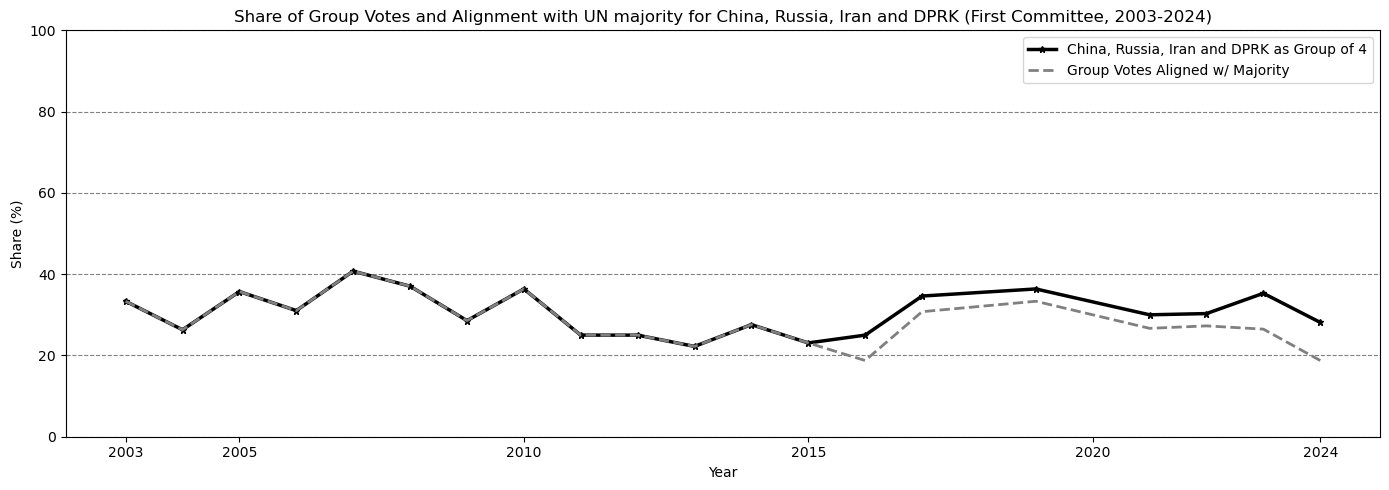

In [130]:
# Cell 21: FIGURE 2 - Share of CRINK Votes as Group of 4 + Alignment with UN Majority

import matplotlib.ticker as ticker

# Get min and max years
min_year = agg.index.min()
max_year = agg.index.max()

# Define 5-year interval ticks and ensure min/max are included
tick_base = 5
main_ticks = list(range(((min_year // tick_base) + 1) * tick_base, max_year, tick_base))
all_ticks = sorted(set([min_year, max_year] + main_ticks))

# Define color schemes based on plot_style
if plot_style == 'bw':
    colors = {4: 'black', 3: 'dimgray', 2: 'gray'}
    linestyles = {4: '-', 3: '--', 2: ':'}
    linewidths = {4: 2.5, 3: 2.5, 2: 2.5}
    markers = {4: 'o', 3: 's', 2: '^'}
else:  # color
    colors = {2: 'darkgreen', 3: 'orange', 4: '#F08080'}
    linestyles = {2: '-', 3: '-', 4: '-'}
    linewidths = {2: 2, 3: 2, 4: 2}
    markers = {2: '.', 3: '.', 4: '.'}

# ---------- Figure 2: Proportions (%) ----------
fig2, ax2 = plt.subplots(figsize=(14, 5))

if len(group) == 2:
    if plot_style == 'bw':
        ax2.plot(prop_percent.index, prop_percent['2_total'],
                 color='black', linestyle='-', linewidth=2.5, marker='o', markersize=5,
                 label='Group of 2')
    else:
        ax2.plot(prop_percent.index, prop_percent['2_total'],
                 color=colors[2], marker='.', label='Group of 2')
else:
    group_label = f'{fmt_names(group)} as Group of 4'
    if plot_style == 'bw':
        ax2.plot(prop_percent.index, prop_percent['4_total'],
                 color='black', linestyle='-', linewidth=2.5, marker='*', markersize=5,
                 label=group_label)
    else:
        ax2.plot(prop_percent.index, prop_percent['4_total'],
                 color=colors[4], marker='.', label=group_label)

# Majority alignment line
majority_color = 'gray' if plot_style == 'bw' else 'black'
majority_linestyle = '--'
majority_linewidth = 2 if plot_style == 'bw' else 2
ax2.plot(prop_percent.index, prop_percent['majority_share'], 
         linestyle=majority_linestyle, color=majority_color, linewidth=majority_linewidth,
         label='Group Votes Aligned w/ Majority')

ax2.set_title(f"Share of Group Votes and Alignment with UN majority for {fmt_names(group)} ({TITLE_SUFFIX})")
ax2.set_ylabel("Share (%)")
ax2.set_ylim(0, 100)
ax2.set_xlabel("Year")
ax2.set_xticks(all_ticks)
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax2.grid(axis='y', linestyle='--', color='gray', linewidth=0.8)
ax2.legend()

fig2.tight_layout()

# Save figure
fig2.savefig(results_dir / f"Figure {FIG_NUM['group_votes']}_Share_of_Group_Votes_and_Alignment_with_UN_Majority_{database.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
print(f"Saved: Figure {FIG_NUM['group_votes']}_Share_of_Group_Votes_and_Alignment_with_UN_Majority_{database.replace(' ', '_')}.png")

plt.show()

C:\Users\Lucian\AppData\Local\Temp\ipykernel_17264\2927936998.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  same = gb.apply(lambda x: (x[a].values == x[b].values).sum()).rename('same')
C:\Users\Lucian\AppData\Local\Temp\ipykernel_17264\2927936998.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  same = gb.apply(lambda x: (x[a].values == x[b].values).sum()).rename('same')
C:\Users\Lucian\AppData\Lo

Saved: Figure 6_Share_of_Identical_Votes_per_Dyad_First_Committee.png


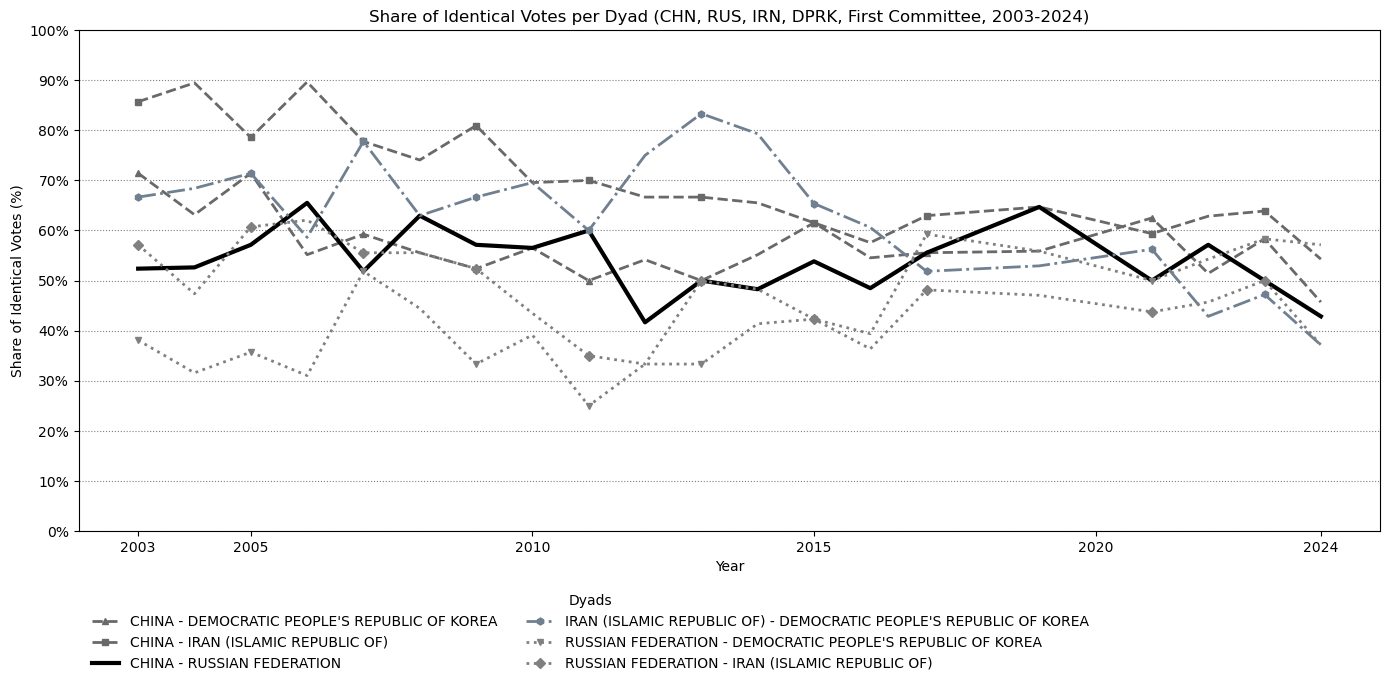

In [131]:
# Cell 22: DYAD PLOT - Share of Identical Votes per Dyad

from itertools import combinations

# --- Load & preprocess data ---
df = get_selected_df()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df = df[(df['year'] >= START_YEAR) & (df['year'] <= END_YEAR)]
df['ms_name'] = df['ms_name'].replace({'USSR': 'RUSSIAN FEDERATION'})

# --- Pivot to wide format (countries as columns) ---
vote_pivot_dyad = df.pivot_table(index=['undl_id', 'date'], columns='ms_name', values='ms_vote', aggfunc='first').reset_index()
vote_pivot_dyad['year'] = pd.to_datetime(vote_pivot_dyad['date']).dt.year

# --- Define countries of interest ---
crink_group = ['CHINA', 'RUSSIAN FEDERATION', 'IRAN (ISLAMIC REPUBLIC OF)', "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA"]
for c in crink_group:
    if c not in vote_pivot_dyad.columns:
        vote_pivot_dyad[c] = pd.NA

# --- Calculate dyad same/different shares per year ---
records = []
for a, b in combinations(crink_group, 2):
    valid = vote_pivot_dyad[a].notna() & vote_pivot_dyad[b].notna()
    gb = vote_pivot_dyad.loc[valid].groupby('year')
    total = gb.size().rename('total')
    same = gb.apply(lambda x: (x[a].values == x[b].values).sum()).rename('same')

    stats = pd.concat([total, same], axis=1)
    stats['share_same'] = (stats['same'] / stats['total']) * 100
    stats['dyad'] = f"{a} - {b}"

    records.append(stats.reset_index())

dyad_year_stats = pd.concat(records, ignore_index=True).sort_values(['dyad', 'year'])

# --- Define ticks ---
min_year_dyad = dyad_year_stats['year'].min()
max_year_dyad = dyad_year_stats['year'].max()
tick_base = 5
main_ticks_dyad = list(range(((min_year_dyad // tick_base) + 1) * tick_base, max_year_dyad, tick_base))
all_ticks_dyad = sorted(set([min_year_dyad, max_year_dyad] + main_ticks_dyad))

# --- Define color scheme ---
if plot_style == 'bw':
    colors_dyad = {
        "CHINA - RUSSIAN FEDERATION": "black",
        "CHINA - IRAN (ISLAMIC REPUBLIC OF)": "dimgray",
        "CHINA - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "dimgray",
        "RUSSIAN FEDERATION - IRAN (ISLAMIC REPUBLIC OF)": "gray",
        "RUSSIAN FEDERATION - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "gray",
        "IRAN (ISLAMIC REPUBLIC OF) - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "slategray"
    }
    linestyles_dyad = {
        "CHINA - RUSSIAN FEDERATION": "-",
        "CHINA - IRAN (ISLAMIC REPUBLIC OF)": "--",
        "CHINA - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "--",
        "RUSSIAN FEDERATION - IRAN (ISLAMIC REPUBLIC OF)": ":",
        "RUSSIAN FEDERATION - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": ":",
        "IRAN (ISLAMIC REPUBLIC OF) - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "-."
    }
    markers_dyad = {
        "CHINA - RUSSIAN FEDERATION": "o",
        "CHINA - IRAN (ISLAMIC REPUBLIC OF)": "s",
        "CHINA - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "^",
        "RUSSIAN FEDERATION - IRAN (ISLAMIC REPUBLIC OF)": "D",
        "RUSSIAN FEDERATION - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "v",
        "IRAN (ISLAMIC REPUBLIC OF) - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "h"
    }
else:
    colors_dyad = {
        "CHINA - RUSSIAN FEDERATION": "darkred",
        "CHINA - IRAN (ISLAMIC REPUBLIC OF)": "#c0392b",
        "CHINA - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "#e74c3c",
        "RUSSIAN FEDERATION - IRAN (ISLAMIC REPUBLIC OF)": "#1f4e79",
        "RUSSIAN FEDERATION - DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "#4a90e2"
    }
    linestyles_dyad = {dyad: '-' for dyad in colors_dyad.keys()}
    linestyles_dyad["CHINA - RUSSIAN FEDERATION"] = "-"
    for dyad in colors_dyad.keys():
        if dyad != "CHINA - RUSSIAN FEDERATION":
            linestyles_dyad[dyad] = "--"
    markers_dyad = {dyad: None for dyad in colors_dyad.keys()}

# --- Plot: dyad line plot ---
fig_dyad, ax_dyad = plt.subplots(figsize=(14, 7))

highlight_dyad = "CHINA - RUSSIAN FEDERATION"

for dyad, data in dyad_year_stats.groupby('dyad'):
    color = colors_dyad.get(dyad, 'gray')
    linestyle = linestyles_dyad.get(dyad, '-')
    marker = markers_dyad.get(dyad, None)
    
    if plot_style == 'bw':
        if dyad == highlight_dyad:
            ax_dyad.plot(data['year'], data['share_same'],
                    color=color, linewidth=3, linestyle=linestyle,
                    markersize=6, markevery=1,
                    label=dyad)
        else:
            ax_dyad.plot(data['year'], data['share_same'],
                    color=color, linewidth=2, linestyle=linestyle,
                    marker=marker, markersize=5, markevery=2,
                    label=dyad)
    else:
        if dyad == highlight_dyad:
            ax_dyad.plot(data['year'], data['share_same'],
                    color=color, linewidth=3.5, linestyle='-',
                    label=dyad)
        else:
            ax_dyad.plot(data['year'], data['share_same'],
                    color=color, linewidth=2, linestyle='--',
                    label=dyad)

# --- Aesthetics for dyad plot ---
ax_dyad.set_title(f"Share of Identical Votes per Dyad (CHN, RUS, IRN, DPRK, {TITLE_SUFFIX})")
ax_dyad.set_ylabel("Share of Identical Votes (%)")
ax_dyad.set_xlabel("Year")
ax_dyad.grid(axis='y', linestyle=':', color='gray', linewidth=0.8)

ax_dyad.set_xticks(all_ticks_dyad)
ax_dyad.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax_dyad.set_ylim(0, 100)
ax_dyad.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax_dyad.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))

ax_dyad.legend(title="Dyads", loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2, frameon=False)

plt.tight_layout()

# Save figure
fig_dyad.savefig(results_dir / f"Figure {FIG_NUM['dyad_votes']}_Share_of_Identical_Votes_per_Dyad_{database.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
print(f"Saved: Figure {FIG_NUM['dyad_votes']}_Share_of_Identical_Votes_per_Dyad_{database.replace(' ', '_')}.png")

plt.show()

Saved: Figure 5_Share_of_CRINK_Coalition_Sizes_by_Year_First_Committee.png


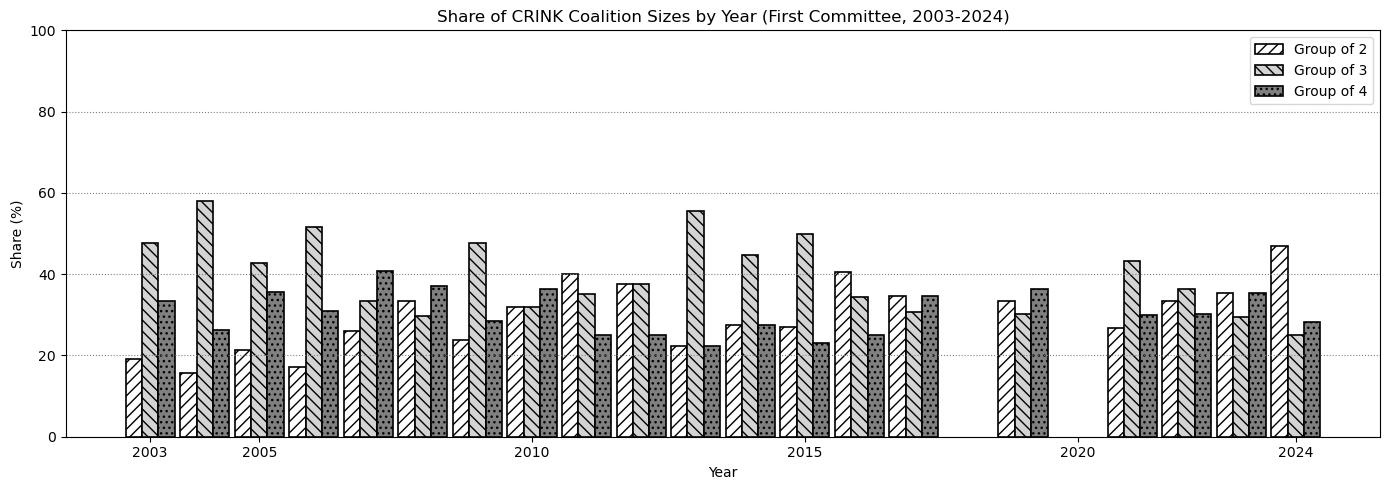

In [132]:
# Cell 23: BAR CHART - Share of CRINK Coalition Sizes by Year

fig_bars, axb = plt.subplots(figsize=(14, 5))
bar_width = 0.3
years = prop_percent.index

if plot_style == 'bw':
    # Use different hatching patterns for black and white
    axb.bar(years - 0.3, prop_percent['2_total'], width=bar_width, 
            color='white', edgecolor='black', linewidth=1.2, hatch='///', label='Group of 2')
    axb.bar(years - 0.0, prop_percent['3_total'], width=bar_width, 
            color='lightgray', edgecolor='black', linewidth=1.2, hatch='\\\\\\', label='Group of 3')
    axb.bar(years + 0.3, prop_percent['4_total'], width=bar_width, 
            color='gray', edgecolor='black', linewidth=1.2, hatch='...', label='Group of 4')
else:
    axb.bar(years - 0.3, prop_percent['2_total'], width=bar_width, 
            color="#8524ac73", label='Group of 2')
    axb.bar(years - 0.0, prop_percent['3_total'], width=bar_width, 
            color="#146d2773", label='Group of 3')
    axb.bar(years + 0.3, prop_percent['4_total'], width=bar_width, 
            color="#d4ca3f5a", label='Group of 4')

axb.set_title(f"Share of CRINK Coalition Sizes by Year ({TITLE_SUFFIX})")
axb.set_ylabel('Share (%)')
axb.set_xlabel('Year')
axb.set_xticks(all_ticks)
axb.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
axb.set_ylim(0, 100)
axb.grid(axis='y', linestyle=':', color='gray', linewidth=0.8)
axb.legend(loc='upper right')

plt.tight_layout()

# Save figure
fig_bars.savefig(results_dir / f"Figure {FIG_NUM['coalition_sizes']}_Share_of_CRINK_Coalition_Sizes_by_Year_{database.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
print(f"Saved: Figure {FIG_NUM['coalition_sizes']}_Share_of_CRINK_Coalition_Sizes_by_Year_{database.replace(' ', '_')}.png")

plt.show()

C:\Users\Lucian\AppData\Local\Temp\ipykernel_17264\286954136.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  different = gb.apply(lambda x: (x[c].values != x[us_col].values).sum())
C:\Users\Lucian\AppData\Local\Temp\ipykernel_17264\286954136.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  different = gb.apply(lambda x: (x[c].values != x[us_col].values).sum())
C:\Users\Lucian\AppData\Local\Temp\ipy

Saved: Figure 8_Voting_Alignment_Against_the_United_States_First_Committee.png


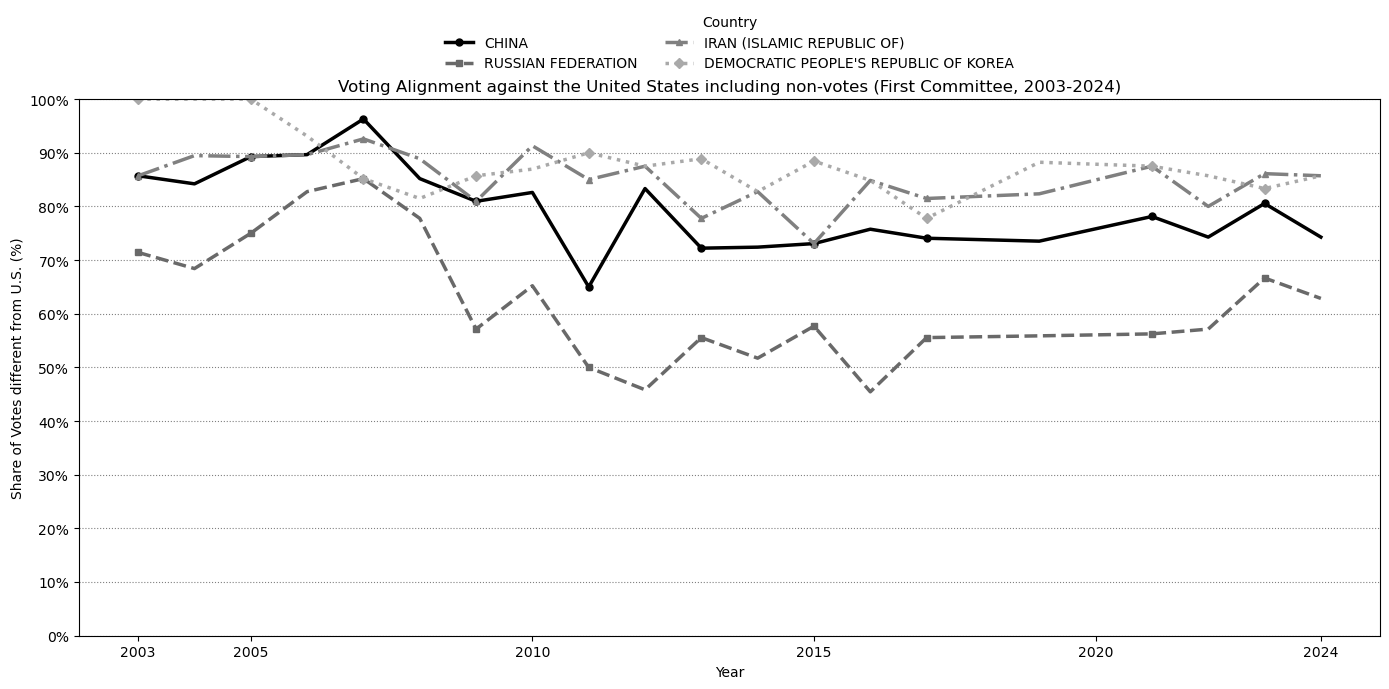

In [133]:
# Cell 24: ANTI-US VOTING - Votes Different from U.S. per CRINK Country

# --- Load & preprocess data ---
df = get_selected_df()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df = df[(df['year'] >= START_YEAR) & (df['year'] <= END_YEAR)]
df['ms_name'] = df['ms_name'].replace({'USSR': 'RUSSIAN FEDERATION'})

# --- Pivot to wide format (countries as columns) ---
vote_pivot_us = df.pivot_table(index=['undl_id', 'date'], columns='ms_name',
                            values='ms_vote', aggfunc='first').reset_index()
vote_pivot_us['year'] = pd.to_datetime(vote_pivot_us['date']).dt.year

# --- Define countries of interest ---
countries = [
    'CHINA',
    'RUSSIAN FEDERATION',
    'IRAN (ISLAMIC REPUBLIC OF)',
    "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA",
]

# --- Identify United States column robustly ---
us_candidates = ['UNITED STATES OF AMERICA', 'UNITED STATES', 'USA']
us_col = next((c for c in us_candidates if c in vote_pivot_us.columns), None)
if us_col is None:
    raise KeyError("No U.S. column found. Tried: 'UNITED STATES OF AMERICA', 'UNITED STATES', 'USA'.")

# Ensure all countries exist
for c in countries:
    if c not in vote_pivot_us.columns:
        vote_pivot_us[c] = pd.NA

# --- Compute yearly alignment (% different votes) with U.S. ---
align_records = []
for c in countries:
    valid = vote_pivot_us[c].notna() & vote_pivot_us[us_col].notna()
    gb = vote_pivot_us.loc[valid].groupby('year')
    total = gb.size()
    different = gb.apply(lambda x: (x[c].values != x[us_col].values).sum())
    stats = pd.DataFrame({
        'year': total.index,
        'share_different': (different / total) * 100,
        'country': c
    })
    align_records.append(stats)

align_df = pd.concat(align_records, ignore_index=True)

# --- Define x-ticks ---
min_year_us = int(align_df['year'].min())
max_year_us = int(align_df['year'].max())
tick_base = 5
main_ticks_us = list(range(((min_year_us // tick_base) + 1) * tick_base, max_year_us, tick_base))
all_ticks_us = sorted(set([min_year_us, max_year_us] + main_ticks_us))

# --- Color scheme ---
if plot_style == 'bw':
    colors_us = {
        'CHINA': 'black',
        'RUSSIAN FEDERATION': 'dimgray',
        'IRAN (ISLAMIC REPUBLIC OF)': 'gray',
        "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": 'darkgray',
    }
    linestyles_us = {
        'CHINA': '-',
        'RUSSIAN FEDERATION': '--',
        'IRAN (ISLAMIC REPUBLIC OF)': '-.',
        "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": ':',
    }
    markers_us = {
        'CHINA': 'o',
        'RUSSIAN FEDERATION': 's',
        'IRAN (ISLAMIC REPUBLIC OF)': '^',
        "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": 'D',
    }
else:
    colors_us = {
        'CHINA': "#c0392b",
        'RUSSIAN FEDERATION': "#1f4e79",
        'IRAN (ISLAMIC REPUBLIC OF)': "#009E73",
        "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "#F58D04",
    }
    linestyles_us = {country: '-' for country in colors_us.keys()}
    markers_us = {country: None for country in colors_us.keys()}

# --- Plot all four lines in one figure ---
fig_us, ax_us = plt.subplots(figsize=(14, 7))

for country in countries:
    data = align_df[align_df['country'] == country]
    if plot_style == 'bw':
        ax_us.plot(data['year'], data['share_different'],
                color=colors_us[country], linewidth=2.5, linestyle=linestyles_us[country],
                marker=markers_us[country], markersize=5, markevery=2,
                label=country)
    else:
        ax_us.plot(data['year'], data['share_different'],
                color=colors_us[country], linewidth=2.5, linestyle='-', 
                label=country)

# --- Formatting & labels ---
ax_us.set_title(f"Voting Alignment against the United States including non-votes ({TITLE_SUFFIX})")
ax_us.set_xlabel("Year")
ax_us.set_ylabel("Share of Votes different from U.S. (%)")
ax_us.grid(axis='y', linestyle=':', color='gray', linewidth=0.8)

ax_us.set_xticks(all_ticks_us)
ax_us.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax_us.set_ylim(0, 100)
ax_us.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax_us.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))

ax_us.legend(
    title="Country",
    loc='lower center',
    bbox_to_anchor=(0.5, 1.03),
    ncol=2,
    frameon=False
)

plt.tight_layout()

# Save figure
fig_us.savefig(results_dir / f"Figure {FIG_NUM['anti_us']}_Voting_Alignment_Against_the_United_States_{database.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
print(f"Saved: Figure {FIG_NUM['anti_us']}_Voting_Alignment_Against_the_United_States_{database.replace(' ', '_')}.png")

plt.show()

In [134]:
# Cell 25: WESTERN DEMOCRACIES ALIGNMENT - Figure 9 (UNGA ONLY)

# Only run for UNGA dataset
if database == 'UNGA':
    # --- Load & preprocess data (same as Cell 18 for CRINK) ---
    df = get_selected_df()

    # --- Pivot format (same logic as CRINK) ---
    vote_pivot = df.pivot_table(index=['undl_id', 'date'], columns='ms_name', values='ms_vote', aggfunc='first').reset_index()

    # --- Define Western countries group ---
    western_group = ['GERMANY', 'FRANCE', 'UNITED KINGDOM', 'UNITED STATES']

    # --- Build list of votes for Western group ---
    vote_pivot['group_votes'] = vote_pivot.apply(lambda row: [row[c] for c in western_group if pd.notna(row[c])], axis=1)
    vote_pivot['group_vote'] = vote_pivot['group_votes'].apply(lambda v: Counter(v).most_common(1)[0][0] if v else None)

    # --- Compute majority vote from all countries ---
    non_country_columns_ext = ['undl_id', 'date', 'group_votes', 'group_vote']
    vote_columns_for_majority = [col for col in vote_pivot.columns if col not in non_country_columns_ext]

    def get_majority_vote(row):
        all_votes = row[vote_columns_for_majority].dropna().values
        most_common = Counter(all_votes).most_common(1)
        return most_common[0][0] if most_common else None

    vote_pivot['group_majority_vote'] = vote_pivot.apply(get_majority_vote, axis=1)

    # --- Final alignment flag for Western democracies ---
    vote_pivot['aligned_with_majority'] = vote_pivot['group_vote'] == vote_pivot['group_majority_vote']

    # --- Ensure year present ---
    vote_pivot['year'] = pd.to_datetime(vote_pivot['date']).dt.year

    # --- Classify by agreement count (same as CRINK) ---
    def classify_group_by_agreement(row):
        votes = [row[c] for c in western_group if pd.notna(row[c])]
        if len(votes) < 2:
            return None
        most_common_vote, count = Counter(votes).most_common(1)[0]
        return count if count >= 2 else None

    vote_pivot['group_type'] = vote_pivot.apply(classify_group_by_agreement, axis=1)

    # --- Aggregate totals and majority alignment (same as CRINK) ---
    filtered = vote_pivot[vote_pivot['group_type'].notnull()]

    agg = (
        filtered
        .groupby(['year', 'group_type'])['aligned_with_majority']
        .agg(total='count', majority='sum')
        .unstack('group_type', fill_value=0)
    )

    # Ensure columns for group sizes 2,3,4 and flatten
    groups = [2, 3, 4]
    agg = agg.reindex(
        columns=pd.MultiIndex.from_product([['total', 'majority'], groups]),
        fill_value=0
    )
    agg.columns = [
        f"{g}_total" if kind == 'total' else f"{g}_majority"
        for kind, g in agg.columns
    ]
    agg = agg.astype(int)

    # --- Compute proportions (same as CRINK) ---
    prop = pd.DataFrame(index=agg.index)
    for g in [2, 3, 4]:
        total_col = f"{g}_total"
        prop[total_col] = agg[total_col] / agg[[f"{g}_total" for g in [2, 3, 4]]].sum(axis=1)

    # --- Calculate majority share (aligned with UN majority as share of ALL votes where group voted together) ---
    prop_percent = prop.copy() * 100
    prop_percent['majority_share'] = ((agg['4_majority']) / (agg['2_total'] + agg['3_total'] + agg['4_total']).replace(0, 1)) * 100

    # --- Plot figure for Western democracies ---
    import matplotlib.ticker as ticker

    min_year_west = agg.index.min()
    max_year_west = agg.index.max()

    tick_base = 5
    main_ticks_west = list(range(((min_year_west // tick_base) + 1) * tick_base, max_year_west, tick_base))
    all_ticks_west = sorted(set([min_year_west, max_year_west] + main_ticks_west))

    # Create figure
    fig_west, ax_west = plt.subplots(figsize=(14, 5))

    # Plot Western democracies as group of 4
    ax_west.plot(prop_percent.index, prop_percent['4_total'],
                 color='black', linestyle='-', linewidth=2.5, marker='o', markersize=3,
                 label='Western Democracies as Group of 4')

    # Plot majority alignment
    ax_west.plot(prop_percent.index, prop_percent['majority_share'],
                 linestyle='--', color='gray', linewidth=2,
                 label='Group Votes Aligned w/ Majority')

    ax_west.set_title(f"Share of Identical Votes by Germany, France, the UK, and the US ({TITLE_SUFFIX})")
    ax_west.set_ylabel("Share (%)")
    ax_west.set_ylim(0, 100)
    ax_west.set_xlabel("Year")
    ax_west.set_xticks(all_ticks_west)
    ax_west.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax_west.grid(axis='y', linestyle='--', color='gray', linewidth=0.8)
    ax_west.legend()

    fig_west.tight_layout()

    # Save figure
    fig_west.savefig(results_dir / f"Figure {FIG_NUM['western']}_Share_of_Western_Democracies_Votes_and_Alignment_with_UN_Majority_{database.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    print(f"Saved: Figure {FIG_NUM['western']}_Share_of_Western_Democracies_Votes_and_Alignment_with_UN_Majority_{database.replace(' ', '_')}.png")

    plt.show()

else:
    print("Note: Western democracies figure (Figure 9) is only generated for UNGA dataset.")


Note: Western democracies figure (Figure 9) is only generated for UNGA dataset.
